
<img src="https://www.unad.edu.co/images/footer/logo-unad-acreditacion-min.png" width="780" height="140" align="right"/>

<p align="center">Curso: Metodos Estadisticos</p>

<p align="center"> Código Curso: 203008067 </p>

<p align="center"> Grupo: 7 </p>

 <p align="center">  Tarea 3: Aprendizaje Estadistico No Supervisado </p>

 <p align="center">  Presentado por: Juan José García Sánchez </p>

<p align="center"> Código: 203008077</p>

 <p align="center"> Tutor(a): Mireya García García </p>

 <p align="center"> 26/11/2024 </p>

 <p align="center"> UNIVERSIDAD NACIONAL ABIERTA Y A DISTANCIA - UNAD </p>



# Objetivo General

### Aplicar modelos de agrupamiento sobre el dataset de precios dinamicos, usando conocimientos de estadistica y  aprendizaje automatico, para realizar un exploración de los datos  y encontrar posibles relaciones o patrones desconocidos entre caracteristicas. 

# Objetivos Especificos

### Examinar la relevancia de las caracteristicas, usando un analisis de componentes principales, para determinar cuales se va usaran en la exploración y clustering del dataset.

### Construir dos modelos de aprendizaje no supervisado, usando los algoritmos de agrupamiento KNN y aglomerativo jerarquico, para realizar un agrupamiento de los datos, y descubrir patrones o similarides entre los puntos de datos. 

### Evaluar los clusteres formados, usando los estadisticos de resumen, metricas y visualizaciones, para hallar su similaridad y relaciones encontradas. 

# Importar librerias

In [1]:
from itertools import chain
from enum import Enum

import pandas as pd
formato = "{:.3f}"
pd.options.display.float_format = formato.format

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, binarize, OneHotEncoder, OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn import metrics
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.decomposition import PCA

# Funciones para Visualización:

Se defininen varias funciones para graficar los resultados del analisis de componentes principales, y de los agrupamientos.

In [3]:
def heatmap(matriz, titulo, formato=".2f", tamaño = (4, 4), mapa="Reds"):
    """
    Presentar un vision grafica de una matrix, com un mapa de calor.
    """
    plt.figure(figsize=tamaño)
    
    sns.heatmap(matriz, annot=True, cmap=mapa, fmt=formato)
    
    plt.title(titulo)

def punto_codo(x, y):
    """
    hallar el punto de codo de un modelo de clasificacion por agrupación,
    o en el contexto de un PCA
    """
    #colocar x en una matrix con y, donde las filas seran el conjunto de puntos: [[x1, y1], [x2, y2], [x3, y3]...]
    puntos = np.vstack((x, y)).T

    extremo_menor = puntos[0,:]

    # vectores diferencia entre el punto menor y cada punto
    dif = extremo_menor - puntos

    # vector diferencia entre el punto extremo mayor y el menor
    dif_extremos = dif[-1,:]

    # Calcular la distancia de cada punto a la línea, usando el producto punto
    norma_extremos = np.linalg.norm(dif_extremos)

    distancias = np.abs(np.cross(dif_extremos, dif)) / norma_extremos

    # El punto con la máxima distancia es el codo
    indice_codo = np.argmax(distancias)
    
    return x[indice_codo]


def grafico_codo(numero_clusteres, suma_distancias, titulos, punto_codo=None):
    """
    realizar un grafico de dispersion de los valores de distorsion o varianza 
    en un analisis de componentes principales. grafica el punto de codo, 
    que supuestamente reduce la dispersion o aumenta la varianza optimamente.
    """
    fig = plt.figure(figsize=(8, 5))

    ax = fig.add_subplot(1, 1, 1)
    
    ax.plot(numero_clusteres, suma_distancias, marker='o', linestyle='-', color='b')
    ax.set_title(titulos[0])
    ax.set_xlabel(titulos[1])
    ax.set_ylabel(titulos[2])

    if punto_codo is not None:
        ax.axvline(x=punto_codo, linestyle='--', color='r', label=f"Codo en x = {punto_codo:d}")
        ax.legend()
        
    ax.grid(True)
    plt.show()
    
def cluster_plot(data, labels, titulos, data_centroides=None, ax=None):
    """
    graficar los puntos de datos y los centroides para los resultados 
    de clasificaciones de agrupamiento.
    """
    
    # Graficar los datos y los centros de clústeres
    if ax is None:
        fig = plt.figure()

        ax = fig.add_subplot(1,1,1)
        
    sns.scatterplot(data, x=titulos[1], y=titulos[2], hue=labels, palette="viridis", ax=ax)

    if data_centroides is not None:
        centroides = (data_centroides.loc[:, titulos[1]], data_centroides.loc[:, titulos[2]])
        
        ax.scatter(*centroides, s=100, marker='^', c='red')

    ax.set_title(titulos[0])
    ax.set_xlabel(titulos[1])
    ax.set_ylabel(titulos[2])        

    plt.show()

def conjunto_cluster_plot(data, titulo, modelo, caracteristicas=None, cmap="viridis", tamaño=None):
    """
    Graficar conjunto de cluster plots, creando un grafico de clusters por cada
    par de variables.
    """

    labels = modelo.labels_
    
    try:
        data_centroides = pd.DataFrame(modelo.cluster_centers_, columns=data.columns)

        def grafico(eje, variable_x, variable_y):
            eje.scatter(data=data, x=variable_x, y=variable_y, c=labels, s=20, marker=".", cmap=paleta)

            centroides = (data_centroides.loc[:, variable_x], data_centroides.loc[:, variable_y])
        
            eje.scatter(*centroides, s=100, marker='^', c='red')
        
    except AttributeError:

        def grafico(eje, variable_x, variable_y):
            eje.scatter(data=data, x=variable_x, y=variable_y, c=labels, s=20, marker=".", cmap=paleta)

    # obtener la paleta de colores, con los mapas de seaborn
    paleta = sns.color_palette(cmap, modelo.n_clusters, as_cmap=True)

    # funcion para indices de combinaciones, dos a dos,
    # para los ejes y las caracteristicas
    def comb(num):
        for idx in range(num):
            for idy in range(idx + 1, num):
                yield idx, idy
                
    def perm(num_filas, num_cols):
        for idx in range(num_filas):
            for idy in range(num_cols):
                yield idx, idy

    # definir cuales son las caracteristicas 
    if caracteristicas is None:
        if tamaño is None:
            tamaño = (20, 20)
            
        caracteristicas = data.columns

        num_filas = num_cols = len(caracteristicas)
    
        # generador de los indices
        indices = comb(num_cols)
    
        #construir grafico de plots multiples:
    
        #obtener figura y conjunto de ejes
        fig = plt.figure(figsize=tamaño, layout="constrained")
    
        axes = fig.subplots(num_filas, num_cols)
    
        # eliminar ejes triangulo superior, vacios
        for idx, idy in comb(num_cols):
            axes[idx, idy].remove()
    
        # eliminar ejes vacios en ultima fila: num_filas - 1 
        for idx in range(num_cols):
            axes[num_filas - 1, idx].remove()
    
        # iterar sobre los pares de caracteristicas y graficar
        
        for idx, idy in indices:
            # obtener el eje en el que se va a graficar con indices
            # hay un desfase de  una fila hacia arriba, para aprovechar los
            # graficos de la diagonal
            
            #idx es el indice de columnas, y idy el de filas, por ser grafico de cuadrillas
            eje = axes[idy - 1, idx]
            
            #tambien, idx se refiere al indice variable x, idy indice variable y, en caracteriscas
            variable_x, variable_y = caracteristicas[idx], caracteristicas[idy]
    
            grafico(eje, variable_x, variable_y)
            
            # graficar titulos y en los graficos de la primera columna: 0
            if idx == 0:
                eje.set_ylabel(variable_y)     
    
            # graficar titulos x en los graficos de la ultima fila: num_filas - 1
            if idy == num_filas - 1 :
                eje.set_xlabel(variable_x)

        #axes[0,0].legend()

    else:
        cant = len(caracteristicas)

        if cant < 4:
            num_filas = 1
            
            num_cols = cant

            def mapeo(idx, idy, axes):
                return axes[idy]

        else:
            num_filas = num_cols = int(np.ceil(np.sqrt(cant)))

            def mapeo(idx, idy, axes):
                return axes[idx, idy]
                
        if tamaño is None:
            tamaño = (5 * num_cols, 5 * num_filas)

        # generador de los indices
        indices = perm(num_filas, num_cols)
    
        #construir grafico de plots multiples:
    
        #obtener figura y conjunto de ejes
        fig = plt.figure(figsize=tamaño, layout="constrained")
    
        axes = fig.subplots(num_filas, num_cols)

        for (variable_x, variable_y), (idx, idy) in zip(caracteristicas, indices):
            # obtener el eje en el que se va a graficar con indices
            #idx es el indice de filas, y idy el de columnas
            eje = mapeo(idx, idy, axes)
            
            grafico(eje, variable_x, variable_y)
    
            eje.set_xlabel(variable_x)        
            
            eje.set_ylabel(variable_y)     

        for idx, idy in indices:
            axes[idx, idy].remove()

        #mapeo(0, 0, axes).legend()
 
    #eje = fig.add_subplot(num_filas, num_cols, id_graf)

    # colocar titulo global de los graficos
    plt.suptitle(titulo)

    plt.show()

# Variables:

Las siguientes clases definen enumeraciones. Su función es simplemente contener constantes en un solo conjunto, para evitar los errores en el codigo.

In [5]:
# Variables categoricas del dataset
class Categ(Enum):
    locacion = "Location_Category"
    lealtad = "Customer_Loyalty_Status"
    tiempo_viaje = "Time_of_Booking"
    vehiculo = "Vehicle_Type"

# Variables numericas del dataset
class Num(Enum):
    viajes_pasados = "Number_of_Past_Rides"
    puntaje_promedio = "Average_Ratings"
    pasajeros = "Number_of_Riders" 	
    conductores = "Number_of_Drivers"
    duracion_esperada = "Expected_Ride_Duration"
    costo_historico = "Historical_Cost_of_Ride"

# Limpieza de datos

Se realiza el cargue de los datos, y se eliminan los datos nulos: 

In [6]:
# Carga los datos en un dataframe de Pandas

#limpiado de datos, el archivo csv debe estar en el mismo directorio
df_crudo = pd.read_csv('Anexo 1- Base de Datos dynamic_pricing.csv')

df_crudo.drop_duplicates()

df_modelos = df_crudo.dropna()

In [5]:
df_modelos

,Number_of_Riders,Number_of_Drivers,Location_Category,Customer_Loyalty_Status,Number_of_Past_Rides,Average_Ratings,Time_of_Booking,Vehicle_Type,Expected_Ride_Duration,Historical_Cost_of_Ride
0,90,45,Urban,Silver,13,4.470,Night,Premium,90,284.257
1,58,39,Suburban,Silver,72,4.060,Evening,Economy,43,173.875
2,42,31,Rural,Silver,0,3.990,Afternoon,Premium,76,329.795
3,89,28,Rural,Regular,67,4.310,Afternoon,Premium,134,470.201
4,78,22,Rural,Regular,74,3.770,Afternoon,Economy,149,579.681
...,...,...,...,...,...,...,...,...,...,...
995,33,23,Urban,Gold,24,4.210,Morning,Premium,11,91.390
996,84,29,Urban,Regular,92,4.550,Morning,Premium,94,424.156
997,44,6,Suburban,Gold,80,4.130,Night,Premium,40,157.365
998,53,27,Suburban,Regular,78,3.630,Night,Premium,58,279.095


# Preparación de los datos.

Para poder realizar los modelos no supervisados, se debe hacer un tratamiento de los datos. Se creó una `Pipeline` llamada `prep` que es comun a todos los modelos que se van a construir y que tiene el proposito de tratar los datos. Esta incluye los siguientes transformadores comunes:

- los datos categoricos se codificaron por medio de las transformadores `OrdinalEncoder` y `OneHotEncoder`. El primero escala variables ordinales, asignandoles un número dependiendo de la importancia jerarquica, en este caso siendo el valor $0$ el primero y con más importancia. El segundo divide las variables categoricas nominales en variables subtitutas que toman valores 1 o 0 (verdadero o falso) dependiendo de si la nominal toma cierto valor del nivel, o no lo toma. Estas transformaciones se aplicaron a todas las variables categoricas, separandolas respectivamente en ordinales o nominales.

- Para realizar el analisis de componentes principales, se necesita realizar una transformación de los datos númericos, para que las diferencias de magnitud no afecten al tratamiento y la interpretación posterior. por esto, se realiza una estandarización: Se centran los datos primero alrededor del promedio, restandoles los promedios por columna, y luego se escalan, dividiendo por la desviacion estandar. Todas las caracteristicas terminan con promedio cero y desviación estandar unitaria, siendo ahora comparables. El transformador usado es el `StandarScaler`, y este escalamiento tambien se aplicó a las categoricas codificadas.

In [7]:
# escalamiento y codificacion de las varialbles, por medio del uso de una pipeline

# se usa la clase ColumnTransformer para juntar varias trasnformaciones juntas, y poder realizarlas en el las variables, como si fuera una sola unidad

orden_ordinales = [["Regular", "Silver", "Gold"], ["Economy", "Premium"]]

prep_categorico = ColumnTransformer([
    ('nominal', OneHotEncoder(), [Categ.locacion.value, Categ.tiempo_viaje.value]),
    ('ordinal', OrdinalEncoder(categories=orden_ordinales), [Categ.lealtad.value, Categ.vehiculo.value]),
                         ],
    remainder='passthrough', force_int_remainder_cols=False)

# creacion de la pipeline de preparación de datos, que se usara en todos los modelos
prep = Pipeline([
    ("prep_categorico", prep_categorico),
    ("estandar", StandardScaler())
])

# creacion de una pipeline para aplicar el analisis de componentes principales preliminar. 
proceso_pca = Pipeline([
    ("preparacion", prep),
    ("PCA", PCA())
    ])

In [9]:
proceso_pca

Pipeline(steps=[('preparacion',
                 Pipeline(steps=[('prep_categorico',
                                  ColumnTransformer(force_int_remainder_cols=False,
                                                    remainder='passthrough',
                                                    transformers=[('nominal',
                                                                   OneHotEncoder(),
                                                                   ['Location_Category',
                                                                    'Time_of_Booking']),
                                                                  ('ordinal',
                                                                   OrdinalEncoder(categories=[['Regular',
                                                                                               'Silver',
                                                                                               'Gold'],
                                                                                              ['Economy',
                                                                                               'Premium']]),
                                                                   ['Customer_Loyalty_Status',
                                                                    'Vehicle_Type'])])),
                                 ('estandar', StandardScaler())])),
                ('PCA', PCA())])

# Analisis de componentes principales (PAC)

El analisis de componentes principales permite crear una serie de nuevas pseudovariables para el analisis de datos, que permiten reducir la dimensionalidad y complejidad del cojunto, mientras se conserva la mayoria de la información contenida en el dataset. Los calculos involucrados utilizan las tecnicas de cálculo de valores y vectores propios, para calcular los pesos y componenentes principales. Se tiene que tener en cuenta que los valores propios seran la varianza explicada por componentes, y los vectores propios seran los componentes como tal, que estaran comformados por los pesos o *loadings* asociados a cada variable.

### Ajuste del modelo:

Se realiza los calculos de valores y vectores propios con la clase `PCA` del paquete sklearn. Hay que tener en cuenta que al codificar las variables categoricas, se tiene un cantidad real de variables de $15$, en lugar de las $10$ del dataset. Los nombres de estas variables nuevas se tienen que extraer de los trasnformadores, para poder referirse a estos luego.

In [8]:
#Ajustando los datos
proceso_pca.fit(df_modelos)

# inspeccionar modelo PCA
modelo_pca= proceso_pca.named_steps["PCA"]

# extraer los nombres de la caracteristicas. como se aplicaron trasnformaciones, las categoricas cambiaron de nombre, y las numericas se pasaron al final, es necesario extraerlas
#para conocer exactamente el nombre y el orden
caract_trans = tuple(
    chain.from_iterable(
        trans.get_feature_names_out() for trans in prep.named_steps["prep_categorico"].named_transformers_.values()
    ))

# Extraccion de la matriz de componenetes, conteniendo los vectores propios calculados.
componentes = pd.DataFrame(modelo_pca.components_, columns=caract_trans)

## Varianza Explicada

### matrix porcentaje varianza y porcentaje acumulado

Se construyó un grafico para visualizar el porcentaje de la varianza total explicada por cada componente. Se observan los valores individuales, asi como una curva con el acumulado total. Como una linea base para juzgar los porcentajes, si la varianza se distribuyera aleatoriamente se esperaria que cada componente explique un $100/15=6.66\%$. Se observa que la direccion de mayor varianza es la que indica el componente 0, que explica el $13\%$ de varianza. las componentes 1-6 superan tienen valores entre el al $8.7\%$ - $11.6\%$, superando bastante la base de $6\%$. El resto de los componentes se acerca a la base, y los componentes 13-14 no explican la varianza. 

Observando la linea de acumulación, se observa un lineal de la varianza explicada hasta llegar a la componente 10, donde se ve un aplanamiento de la curva. Esto sugiere que los componentes 0-10 son los mas significativos, y se deberian tomar para hacer una reducción de dimensionalidad, reduciendose de las 15 variables a 11 pseudovariables.

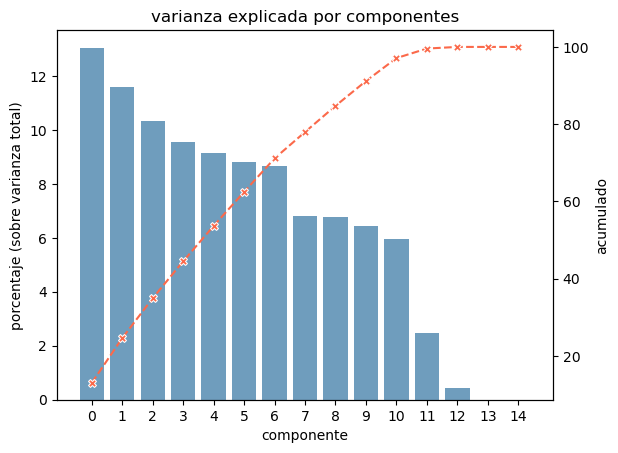

In [11]:
# calculo de varianza acumumalada
varianza_acumulada = pd.DataFrame(modelo_pca.explained_variance_ratio_).transform("cumsum") * 100

#grafico de barras de porcentajes
ax = sns.barplot(modelo_pca.explained_variance_ratio_*100, alpha=0.7)

# colocar titulos
ax.set_title("varianza explicada por componentes")
ax.set_xlabel("componente")
ax.set_ylabel("porcentaje (sobre varianza total)")

# grafico lineal de la varianza acumulada

ax2 = ax.twinx()
ax2.set_ylabel("acumulado")

sns.lineplot(varianza_acumulada, legend=False, palette="Reds",  marker="X", ax = ax2)
ax2.lines[0].set_linestyle("--")

plt.show()

### Screeplot varianza explicada 

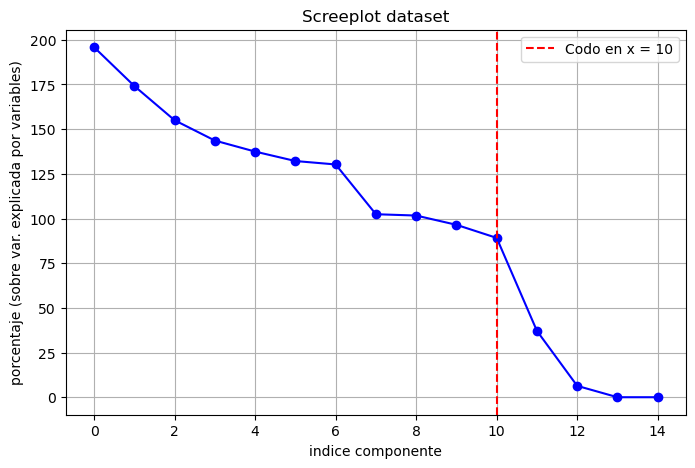

In [9]:
indices_comp = np.arange(15)

porcentaje_sobre_variables = modelo_pca.explained_variance_*100

codo = punto_codo(indices_comp, porcentaje_sobre_variables)

grafico_codo(indices_comp, 
             porcentaje_sobre_variables, 
             ("Screeplot dataset", "indice componente", "porcentaje (sobre var. explicada por variables)"),  
             punto_codo=codo)

### Analisis:

El screeplot muestra que la varianza explicada de los componenentes 0-8 es bastante alta, ya que explican igual o más del 100% de la varianza, respecto a la explicada por las caracteristicas unicamente. Las demás componentes tiene un porcentaje menor, y se desempeñan peor.

El punto de codo calculado nos dice cual es el número de componentes que deberian tomarse para reducir dimensionalidad. En este caso se muestra que deberian tomarse 11 componentes. Este resultado coincide con la disminución significativa de la varianza total que se observa en el grafico anterior. Ambos metodos terminan estando de acuerdo sobre el numero de componentes.


## Visualizar loadings de los componentes.

Se construyó un mapa de calor mostrando los componenes, con de la matriz de loadings. Esta matriz esta contenida en `mode_pca.components_`.

Se observa que la mayoria del grafico tiene un color casi uniforme verde, indicando valores cercanos a cero. Los cuadros que son más azules o mas amarillos son los de interes, y revelan que variables en cada componentes tienen mas relevancia. para cada uno de los 15 componentes se tienen las siguientes variables relevantes:

- 0: pesos positivos para la duración esperada del viaje y el costo historico.
- 1: pesos positivos para el número de pasajeros y número de conductores, y negativo para la locación, en su nivel *Rural*
- 2: peso negativo para la locacion *suburbana* y positivo para *Urbana*.
- 3: pesos positivos para el nivel *Rural* de la variable locacion, el nivel *noche* de la variable tiempo viaje, cantidad de pasajeros y de conductores; peso negativo alto para el nivel "suburbano" de la variable locación
- 4: peso positivo alto para el nivel *tarde* de la variable hora de viaje. 
- 5: pesos negativos a los niveles *anochecer* y peso positivo al nivel de la *noche*, de la variable *tiempo de viaje*.
- 6: peso negativo al nivel *anochecer*, y positivo al nivel de *mañana*, en la variable tiempo de viaje.
- 7: pesos positivos al tipo de vehiculo, y al puntaje promedio, peso negativo al numero de viajes pasados.
- 8: peso positivo alto para la lealtad del usuario, pesos negativos para  
- 9: pesos positivos a la lealtad del usario, al tipo de vehiculo y pesos negativos al numero de viajes pasados, y el puntaje promedio.
- 10: pesos positivos a la lealtad del usario, al tipo de vehiculo, el numero de viajes pasados, y el puntaje promedio.
- 11: peso positivo al número de conductores, y peso negatvivo a la cantidad de pasajeros.
- 12: Peso negativo a la variable de duración esperada, y positivo a la variable costo historico.
- 13: Pesos positivos y similares, a todos los niveles de la variable locación.
- 14: Pesos positivos, y similares, a todos los niveles de la variable de Hora del viaje.

La componente $0$ es la que mas varianza explica de todas, y esta favorece las variables de la duración esperada y el costo historico. 

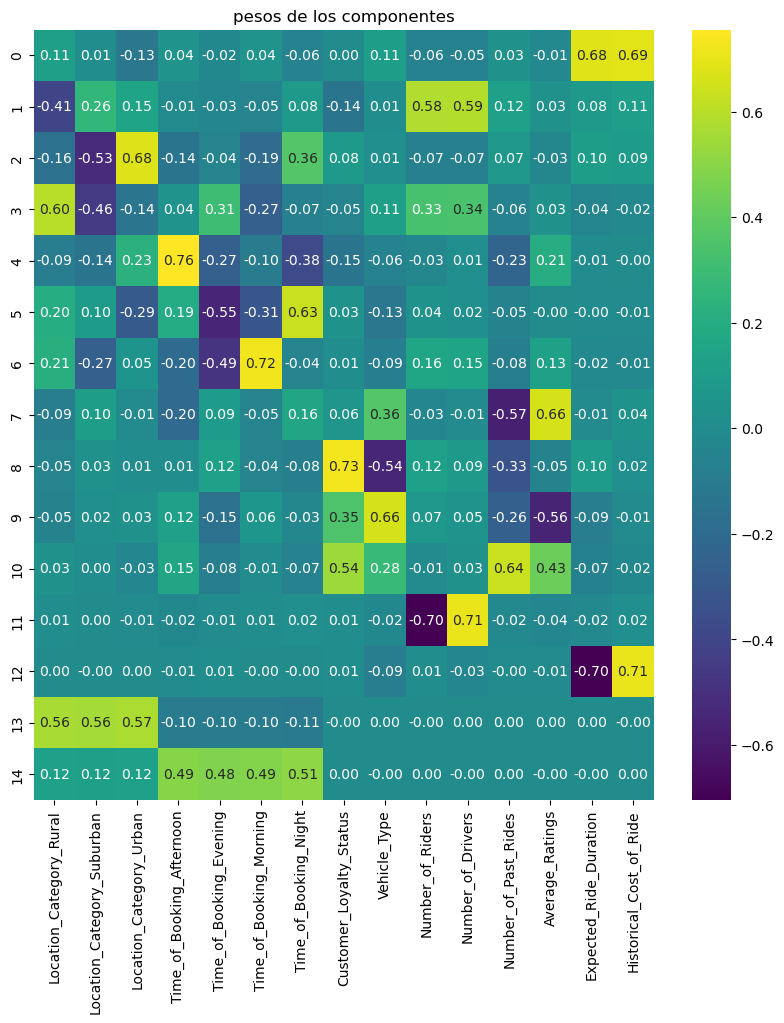

In [10]:
heatmap(componentes, "pesos de los componentes",  tamaño=(10,10), mapa="viridis")

# KNN (Agrupamiento K-Medias)

El metodo de los k vecinos mas cercanos utiliza un metodo de medición democratico para encontrar las similaridades entre los puntos muestrales: se calcula un punto que es el resumen de todos los puntos en los datos, llamado centroide, y va agregando los puntos que se acerquen mas al centroide. Con este nuevo cluster se calcula nuevamente el centroide, y se repite el proceso. los centroides se generan aleatoriamente al inicio del entrenamiento, y la distancia se calcula con una formula, que en la mayoria de los casos es una distancia euclidiana simple. El modelo de KNN se entrenó en este caso con el clasificador `KMeans`, que implementa el metodo de los k vecinos mas cercanos. 

El metodo del KNN no puede usarse directamente con el dataset, ya que no trabaja con tipos de datos mixtos. Tambien es bastante sensible a la presencia de outliers, a la escala y distribución de los datos, y a las suposiciones aleatorias de los clusteres al inicio del proceso. Por esta razón los datos input se codificaran y estandarizaran inicialmente, y luego se les aplicara el entrenamiento de componentes principales previamente utilizado para resolver la mayoria de los problemas con el algoritmo KNN.

### Ajuste del modelo:

In [25]:
# K-Means con 4 clusters
n_clusters_knn = 4

# numero de componentes
num_pca_knn = 11

# construccion pipeline
proceso_knn = Pipeline([
    ("preparacion", prep),
    ("PCA", PCA(num_pca_knn)),
    ("KNN", KMeans(n_clusters=n_clusters_knn, init='random', n_init=10, max_iter=300, tol=1e-04, random_state=600))
    ])

modelo_knn= proceso_knn.named_steps["KNN"]

proceso_knn.fit(df_modelos)

Pipeline(steps=[('preparacion',
                 Pipeline(steps=[('prep_categorico',
                                  ColumnTransformer(force_int_remainder_cols=False,
                                                    remainder='passthrough',
                                                    transformers=[('nominal',
                                                                   OneHotEncoder(),
                                                                   ['Location_Category',
                                                                    'Time_of_Booking']),
                                                                  ('ordinal',
                                                                   OrdinalEncoder(categories=[['Regular',
                                                                                               'Silver',
                                                                                               'Gold'],
                                                                                              ['Economy',
                                                                                               'Premium']]),
                                                                   ['Customer_Loyalty_Status',
                                                                    'Vehicle_Type'])])),
                                 ('estandar', StandardScaler())])),
                ('PCA', PCA(n_components=11)),
                ('KNN',
                 KMeans(init='random', n_clusters=4, n_init=10,
                        random_state=600))])

In [13]:
# Obtener los centros de los clústeres y las etiquetas de clúster para cada punto de datos
pseudo_caract = tuple(f"PC{n}" for n in range(num_pca_knn))

# transformar datos, usando la pipeline de preparacion, y usar en las graficas despues
df_prep_knn = pd.DataFrame(proceso_knn[:-1].transform(df_modelos), columns=pseudo_caract)

# obtener clusteres para contarlos y analizarlos, agregandolos a la matriz de datos
df_knn = pd.concat((df_modelos, pd.DataFrame({"cluster": modelo_knn.labels_})), axis=1)

# obtener los centroides, para analizarlos.
centroides = pd.DataFrame(modelo_knn.cluster_centers_)

## Tamaño de los clusteres

In [14]:
df_knn["cluster"].value_counts().sort_index()

cluster
0    246
1    276
2    231
3    247
Name: count, dtype: int64

In [65]:
# medidas de resumen para variables numericas
caracteristicas = [m.value for m in Num] + ["cluster"] 

#agrupar los registros por la columna con el cluster y obtener medidas de resumen
df_knn[caracteristicas].groupby(["cluster"]).agg(["mean", "std", "min", 
                                                  lambda x: np.quantile(x, 0.25), lambda x: np.quantile(x, 0.5), lambda x: np.quantile(x, 0.75), 
                                                  "max"]).T.rename(index={'<lambda_0>':"25%", '<lambda_1>':"50%", '<lambda_2>':"75%"})

cluster                            0       1       2       3
Number_of_Past_Rides    mean  49.740  52.293  51.814  46.126
                        std   30.415  29.374  28.389  28.742
                        min    0.000   1.000   0.000   0.000
                        25%   23.250  25.750  27.500  24.000
                        50%   50.000  55.000  53.000  42.000
                        75%   75.000  79.000  74.000  72.000
                        max  100.000 100.000 100.000 100.000
Average_Ratings         mean   4.272   4.236   4.232   4.291
                        std    0.421   0.454   0.438   0.427
                        min    3.510   3.500   3.500   3.500
                        25%    3.955   3.808   3.845   3.960
                        50%    4.265   4.280   4.230   4.300
                        75%    4.622   4.630   4.595   4.680
                        max    5.000   5.000   5.000   4.990
Number_of_Riders        mean  59.654  61.627  60.519  59.547
                        std   24.425  23.507  23.237  23.698
                        min   20.000  20.000  20.000  21.000
                        25%   38.000  42.000  40.000  38.500
                        50%   59.000  61.000  61.000  57.000
                        75%   82.750  83.000  79.000  81.000
                        max  100.000 100.000 100.000 100.000
Number_of_Drivers       mean  26.171  27.203  27.485  27.453
                        std   18.054  19.661  19.332  19.216
                        min    5.000   5.000   5.000   5.000
                        25%   11.000  11.000  12.000  12.000
                        50%   21.500  22.000  23.000  22.000
                        75%   37.000  37.000  38.000  39.500
                        max   82.000  80.000  85.000  89.000
Expected_Ride_Duration  mean 100.931  98.362  98.108 101.004
                        std   47.736  48.804  50.598  49.830
                        min   11.000  10.000  10.000  10.000
                        25%   60.250  61.000  54.000  60.000
                        50%  103.000  95.000 101.000 107.000
                        75%  140.750 141.000 143.000 146.000
                        max  180.000 180.000 180.000 180.000
Historical_Cost_of_Ride mean 378.062 367.009 364.254 380.818
                        std  180.417 187.613 185.310 195.394
                        min   39.374  38.235  25.993  31.362
                        25%  229.018 227.513 216.596 216.971
                        50%  382.233 336.092 360.711 387.476
                        75%  509.634 504.558 501.324 529.134
                        max  784.055 828.213 812.073 836.116

## Analisis

Se observa que los tamaños de los clusteres son muy similares, siendo el mas grande el grupo 1. Observando las medidas de resumen se nota
que los maximos y los minimos de las variables categoricas son muy similares, siendo iguales con el *numero de viajes pasados*, *el puntaje promedio*, *el número conductores*, y *la duracion esperada*; se diferencia notablemente en el costo historico, donde el grupo 0 tiene el valor menor de *784*. 

Se observa que todos los cuartiles son muy similares, indicando una distribucion similar de los datos entre los clusteres, que se debe al entrenamiento posterior que se realizó con los componentes principales. La similaridad muestra que las variables numericas no tienen tanta influencia en el algoritmo de clasificación. Las diferencias principales se explican con los clusteres a continuación. 

## Centroides

In [16]:
res = proceso_knn.named_steps["PCA"].inverse_transform(centroides)

pd.DataFrame(proceso_knn.named_steps["preparacion"]["estandar"].inverse_transform(res), columns=caract_trans)

,Location_Category_Rural,Location_Category_Suburban,Location_Category_Urban,Time_of_Booking_Afternoon,Time_of_Booking_Evening,Time_of_Booking_Morning,Time_of_Booking_Night,Customer_Loyalty_Status,Vehicle_Type,Number_of_Riders,Number_of_Drivers,Number_of_Past_Rides,Average_Ratings,Expected_Ride_Duration,Historical_Cost_of_Ride
0,0.329,0.354,0.317,0.000,0.000,1.000,-0.000,1.000,0.508,59.734,26.106,49.742,4.272,100.925,378.083
1,0.308,0.297,0.395,0.000,0.000,-0.000,1.000,1.043,0.507,61.827,27.041,52.300,4.236,98.372,366.971
2,0.359,0.307,0.333,-0.000,1.000,0.000,0.000,1.009,0.576,60.457,27.536,51.812,4.231,98.141,364.130
3,0.336,0.332,0.332,1.000,-0.000,0.000,0.000,0.915,0.502,59.302,27.651,46.118,4.291,100.969,380.956


Para entender los centroides, se invirtieron la estandarización que se realizo a los datos, para obtener a que valores reales corresponden. Este proceso no funciona con las variables categoricas de la *locación* y *el tipo de vehiculo*, ya que los valores resultantes no se corresponden con la codificacion que se les dio al inicio.

La primera diferencia entre los clusters se da en la variable del *tiempo de viaje*, siendo diferente en cada cluster: 

- 0: nivel *mañana*
- 1: nivel *noche*
- 2: nivel *anochecer*
- 3: nivel *tarde*

Esto muestra que uno de los criterios de clasificación fue la hora del dia, y que hay similaridades entre grupos de tiempo para agrupar. Las demas variables categoricas no se ubicaron en valores especificos usados para la clasificacion, sino en valores intermedios, por lo que el algoritmo de agrupación intento igualar esas variables. Se entrenó otro modelo excluyendo la variable del *tiempo de viaje*, y se encontró que el modelo agrupa nuevamente usando otra variable categorica: *locacion de viaje*. El algoritmo de KNN debe de estar elegiendo una variable categorica para agrupar por los diferentes niveles.

Revisando las variables numericas, todos los clusteres tiene valores similares. Las excepciones son en el *numero de viajes pasados*, y *costo historico*, donde se ve que algunos clusteres tiene una diferencia algo más grande. Esto nos indica que las variables categoricas son el criterio principal para el agrupamiento. Si se quiere explorar más los grupos, es necesario eliminar o disminuir el peso de las variables categoricas en el algoritmo KNN.

### Visualización:

Tomando en cuenta las combinaciones de 11 componentes que se pueden hacer, hay 55 graficos que se pueden realizar para visualizar los clusteres. En este trabajo se graficaron todos los clusteres y se seleccionaron solamente aquellos que presentaran con mayor claridad las agrupaciones. los colores correspondend a los niveles de la variable *tiempo viaje*:

- morado: nivel *mañana*
- amarillo: nivel *tarde*
- verde: nivel *anochecer*
- azul: nivel *noche*

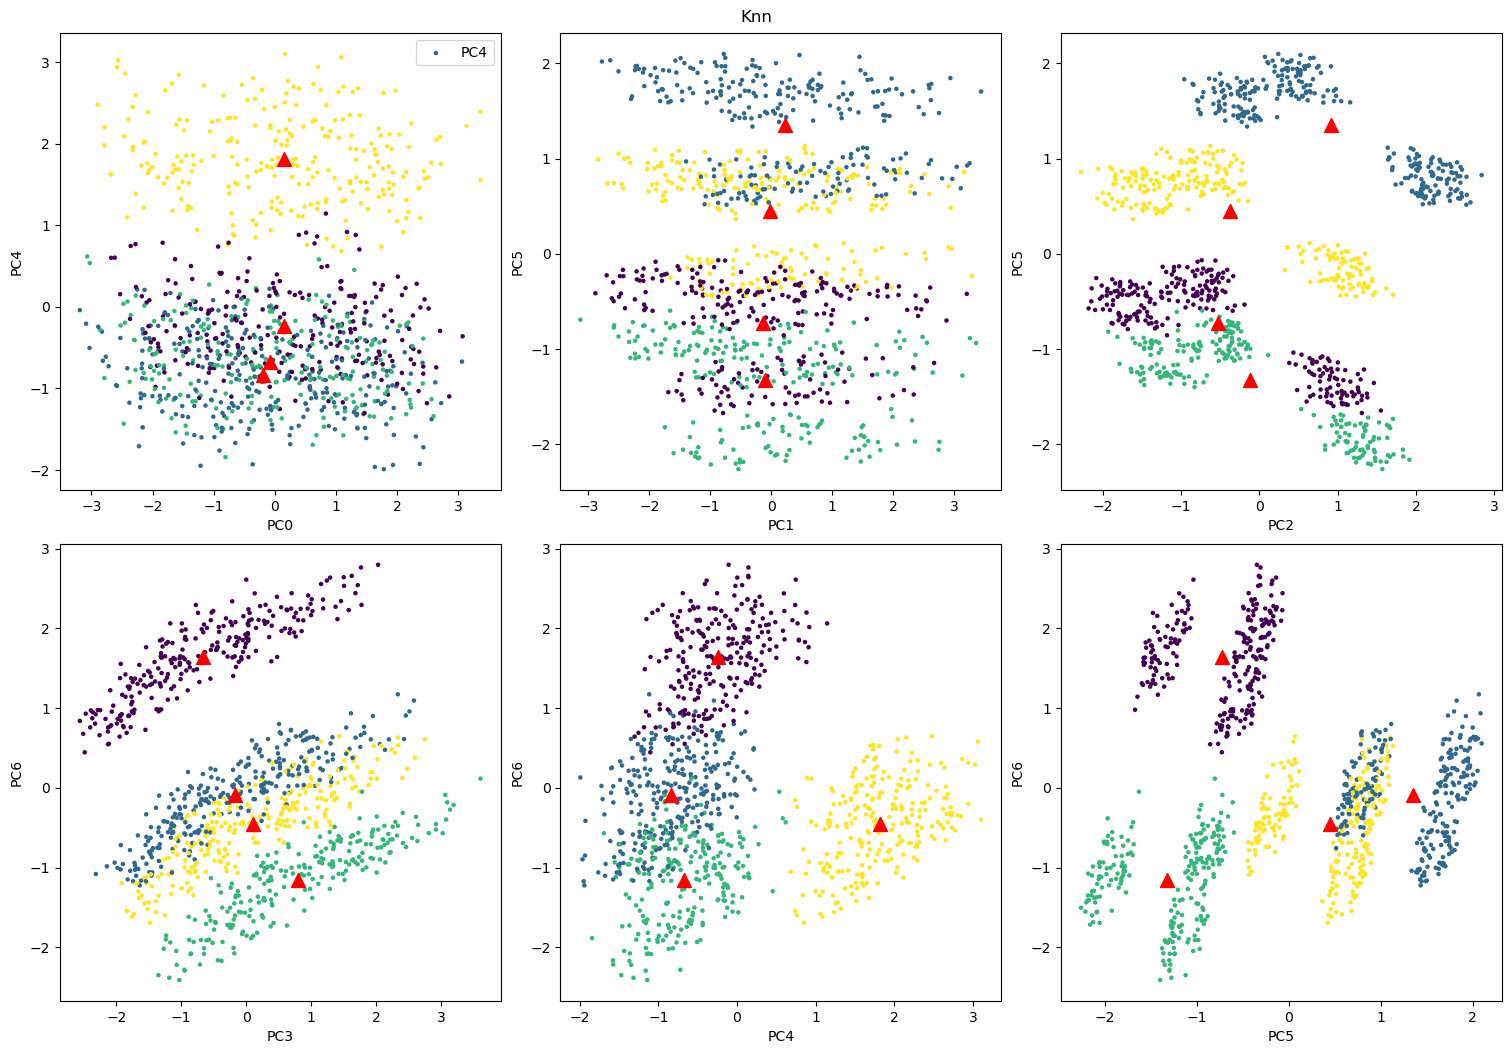

In [71]:
# Graficar los datos coloreados por sus etiquetas de clúster
pares = [("PC0","PC4"), ("PC1","PC5"), ("PC2","PC5"), ("PC3","PC6"), ("PC4","PC6"), ("PC5","PC6"),]

# para graficar todas las combinaciones de componentes, reemplazar parametro caracteristicas, de pares a None
conjunto_cluster_plot(df_prep_knn, "Knn", modelo_knn, caracteristicas=pares)

### Analisis:

Estos graficos son donde se ven mas claramente las agrupaciones e involucran el uso de los componentes 0-6. En cada uno se grafica ya sea contra PC5, o PC6, ya que estos componentes dan mas peso a los niveles de la variable de *Tiempo de viaje*, y la clasificación fue realizada por el modelo principalmente con esa variable categorica.

En cada grafico, se puede ver que la forma de los clusteres es muy similar, y los grupos se diferencian mas que todo por un desplazamiento. Este dezplazamiento corresponde a las diferencias que hay entre las caracteristicas, y entre los niveles del *tiempo de viaje* a los cuales corresponden cada uno. En los graficos 1 y 5, se pueden ver que se mezclan los clusteres de la *mañana*, *anochecer* y *noche*, y se separa el cluster de la *tarde*. Es muestra que hay mucha mas similaridad entre los primeros tres, y el cluster de la tarde es diferente de los tres. Los graficos 3 y 6 muestran que se puede separar aun más los datos, ya que hay divisiones internas entre clusteres entre esas variables.

# Agrupamiento Jerarquico

El modelo de agrupamiento jerarquico agrupa puntos de datos formando miniclusteres, separandolos o juntandolos sucesivamente. El resultado depende de un metodo de enlace usado, que es una metrica para calcular la similaridad de puntos de datos. En este caso se usa la clase `AgglomerativeClustering`, con el metodo de enlace `ward`, que minimiza la suma de diferencias entre puntos del cluster. 

El cluster aglomerativo tiene como desventajas que su implementación hace que sea computacionalmente complejo y que no funcione bien con tipos de datos mixtos, o que tengan escalas diferentes, distribuciones diferentes, o outliers. Para superar estos problemas se puede reducir el numero de variables, y codificar las que sean de tipo no numerico. En este trabajo, se usara un entrenamiento previo, con los componentes principales hallados para aprovechar la reducción de dimensionalidad, y hacer más facil la computación ya que se usaran las variables estandarizadas.

### Ajuste del modelo:

Para el entrenamiento del cluster aglomerativo, se eligió un número de componentes principales de 11 que se habian hallado previamente, y se usaron 4 clusteres para realizar las clasificaciones finalmente.

In [18]:
# K-Means con 4 clusters
n_clusters_agg = 4

# numero de componentes
num_pca_agg = 11

proceso_agg = Pipeline([
    ("preparacion", prep),
    ("PCA", PCA(num_pca_agg)),
    ("AGG", AgglomerativeClustering(n_clusters=n_clusters_agg))
    ])

modelo_agg= proceso_agg.named_steps["AGG"]

proceso_agg.fit(df_modelos)

Pipeline(steps=[('preparacion',
                 Pipeline(steps=[('prep_categorico',
                                  ColumnTransformer(force_int_remainder_cols=False,
                                                    remainder='passthrough',
                                                    transformers=[('nominal',
                                                                   OneHotEncoder(),
                                                                   ['Location_Category',
                                                                    'Time_of_Booking']),
                                                                  ('ordinal',
                                                                   OrdinalEncoder(categories=[['Regular',
                                                                                               'Silver',
                                                                                               'Gold'],
                                                                                              ['Economy',
                                                                                               'Premium']]),
                                                                   ['Customer_Loyalty_Status',
                                                                    'Vehicle_Type'])])),
                                 ('estandar', StandardScaler())])),
                ('PCA', PCA(n_components=11)),
                ('AGG', AgglomerativeClustering(n_clusters=4))])

In [19]:
# Obtener los centros de los clústeres y las etiquetas de clúster para cada punto de datos
pseudo_caract = tuple(f"PC{n}" for n in range(num_pca_agg))

# transformar datos, usando la pipeline de preparacion, y usar en las graficas despues
df_prep_agg = pd.DataFrame(proceso_agg[:-1].transform(df_modelos), columns=pseudo_caract)

# obtener clusteres para contarlos y analizarlos, agregandolos a la matriz de datos
df_agg = pd.concat((df_modelos, pd.DataFrame({"cluster": modelo_agg.labels_})), axis=1)

## Tamaño de los clusteres

In [20]:
df_agg["cluster"].value_counts()

cluster
0    276
2    247
1    246
3    231
Name: count, dtype: int64

In [21]:
df_agg[[m.value for m in Num] + ["cluster"]].groupby(["cluster"]).agg(["mean", "std", "min", 
                                                  lambda x: np.quantile(x, 0.25), lambda x: np.quantile(x, 0.5), lambda x: np.quantile(x, 0.75), 
                                                  "max"]).T.rename(index={'<lambda_0>':"25%", '<lambda_1>':"50%", '<lambda_2>':"75%"})

cluster                            0       1       2       3
Number_of_Past_Rides    mean  52.293  49.740  46.126  51.814
                        std   29.374  30.415  28.742  28.389
                        min    1.000   0.000   0.000   0.000
                        25%   25.750  23.250  24.000  27.500
                        50%   55.000  50.000  42.000  53.000
                        75%   79.000  75.000  72.000  74.000
                        max  100.000 100.000 100.000 100.000
Average_Ratings         mean   4.236   4.272   4.291   4.232
                        std    0.454   0.421   0.427   0.438
                        min    3.500   3.510   3.500   3.500
                        25%    3.808   3.955   3.960   3.845
                        50%    4.280   4.265   4.300   4.230
                        75%    4.630   4.622   4.680   4.595
                        max    5.000   5.000   4.990   5.000
Number_of_Riders        mean  61.627  59.654  59.547  60.519
                        std   23.507  24.425  23.698  23.237
                        min   20.000  20.000  21.000  20.000
                        25%   42.000  38.000  38.500  40.000
                        50%   61.000  59.000  57.000  61.000
                        75%   83.000  82.750  81.000  79.000
                        max  100.000 100.000 100.000 100.000
Number_of_Drivers       mean  27.203  26.171  27.453  27.485
                        std   19.661  18.054  19.216  19.332
                        min    5.000   5.000   5.000   5.000
                        25%   11.000  11.000  12.000  12.000
                        50%   22.000  21.500  22.000  23.000
                        75%   37.000  37.000  39.500  38.000
                        max   80.000  82.000  89.000  85.000
Expected_Ride_Duration  mean  98.362 100.931 101.004  98.108
                        std   48.804  47.736  49.830  50.598
                        min   10.000  11.000  10.000  10.000
                        25%   61.000  60.250  60.000  54.000
                        50%   95.000 103.000 107.000 101.000
                        75%  141.000 140.750 146.000 143.000
                        max  180.000 180.000 180.000 180.000
Historical_Cost_of_Ride mean 367.009 378.062 380.818 364.254
                        std  187.613 180.417 195.394 185.310
                        min   38.235  39.374  31.362  25.993
                        25%  227.513 229.018 216.971 216.596
                        50%  336.092 382.233 387.476 360.711
                        75%  504.558 509.634 529.134 501.324
                        max  828.213 784.055 836.116 812.073

### Analisis 

Se puede observar que los cuatro clusteres tienen tamaños similares, siendo el mayoritario el cluster 0, que corresponde al nivel de la mañana. Los estadisticos de resumen son similares en todos los clusteres, para todas las variables, lo que indica que las agrupaciones son bastante similares excepto por la hora del dia, como sucedió con la agrupación KNN. Esto es debido a la estandarización, y tambien por la influencia de las variables categoricas. Para obtener resultados más interesantes o reveladores, se debe eliminar o dar menor peso a las variables categoricas, para observar que patrones surgen en las numericas.

### Visualización:

En el caso del agrupamiento jerarquico, se encontraron 8 graficos donde se puede visualizar de forma clara las agrupaciones. los colores siguen un orden ligeramente distino, que en el caso del modelo KNN: 

- morado: nivel *mañana*
- verde : nivel *tarde*
- vamarillo : nivel *anochecer*
- azul: nivel *noche*

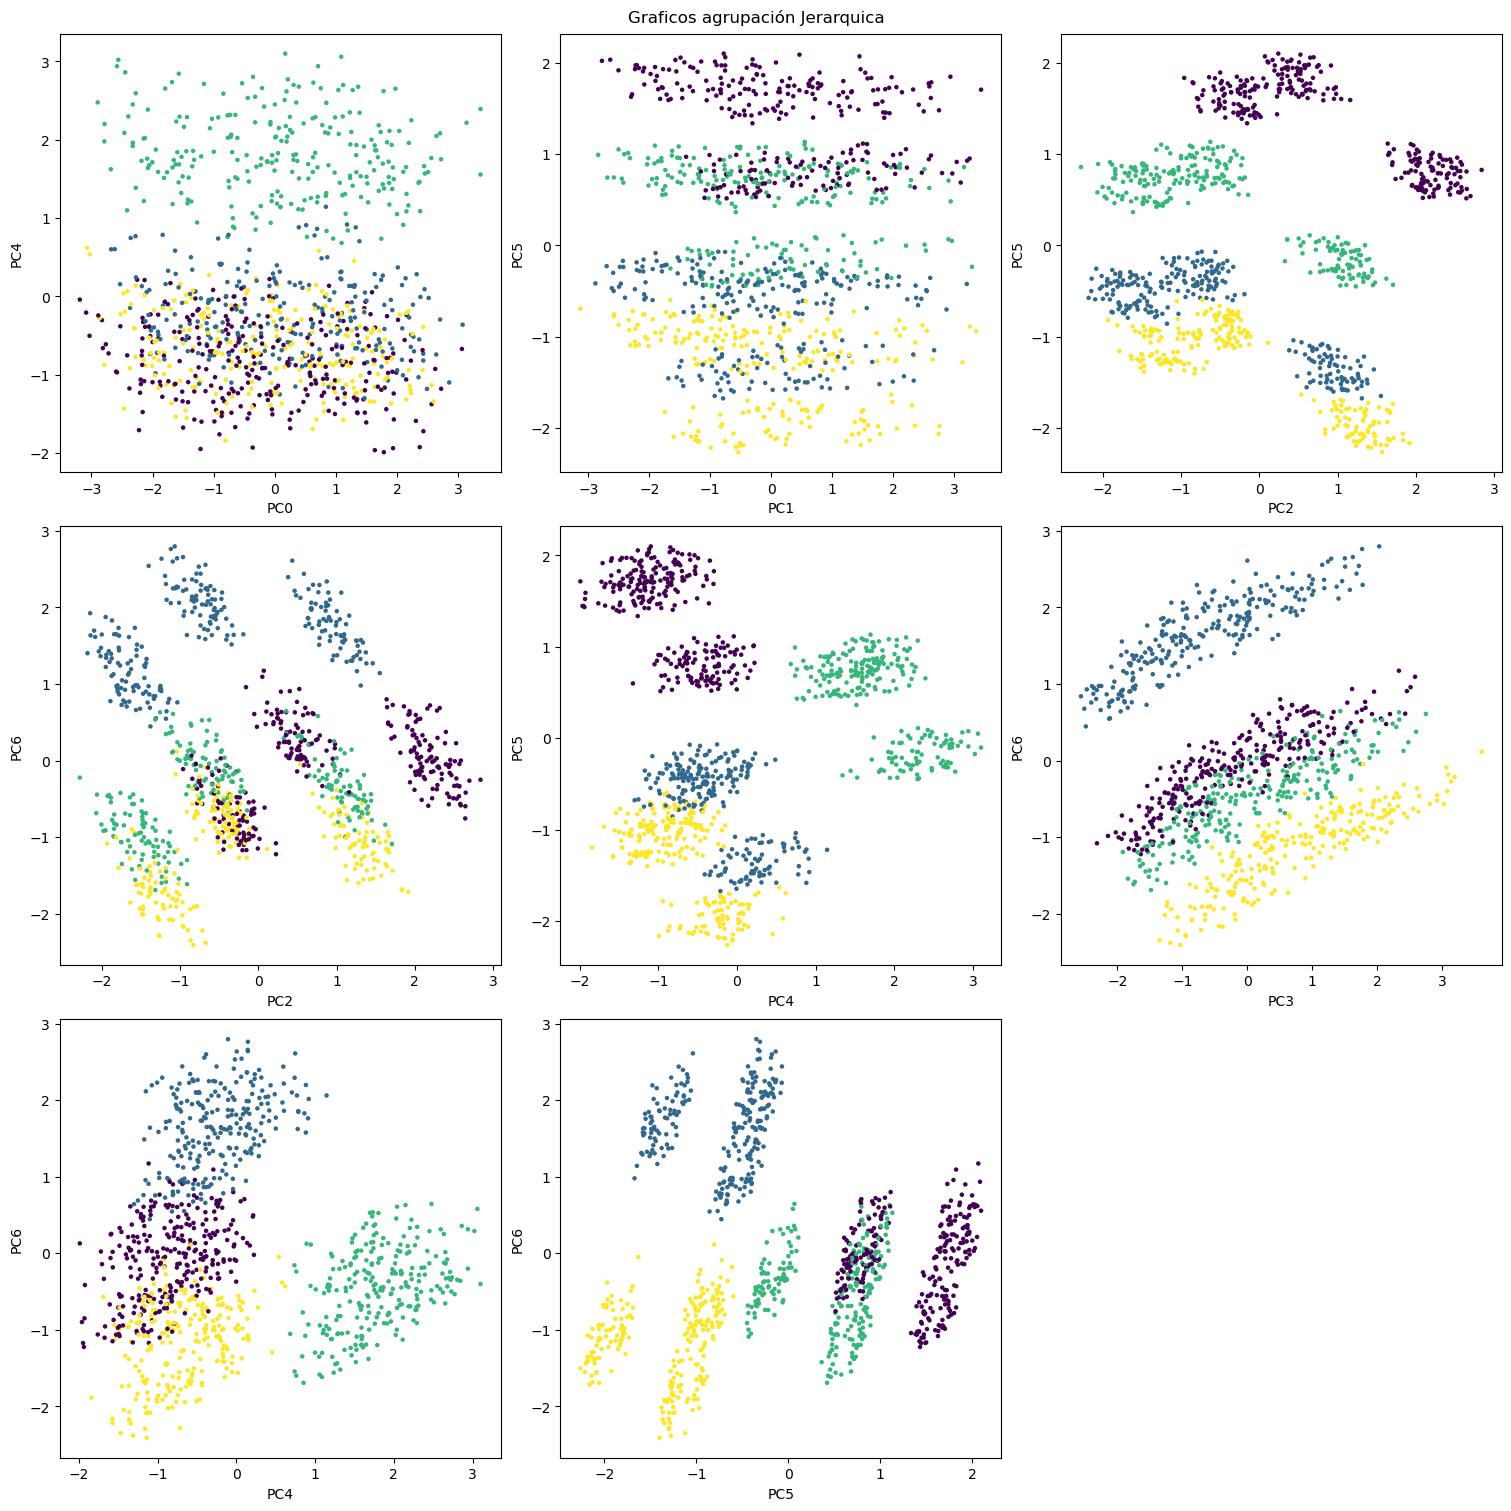

In [22]:
# Graficar los datos coloreados por sus etiquetas de clúster
pares = [("PC0","PC4"), ("PC1","PC5"), ("PC2","PC5"), ("PC2","PC6"), ("PC4", "PC5"), ("PC3","PC6"), ("PC4","PC6"), ("PC5","PC6"),]

# para graficar todas las combinaciones de componentes, reemplazar parametro caracteristicas, de pares a None
conjunto_cluster_plot(df_prep_agg, "Graficos agrupación Jerarquica", modelo_agg, caracteristicas=pares)

### Analisis 

El resultado de la agrupación jerarquica se parace al resultado del modelo KNN. Esto es debido a la similaridad de los metodos. Tambien se puede oabservar que los componentes 5 y 6 son las variables donde se pueden ver más claramente las agrupaciones. Los graficos de clusteres se be igualmente similares, y se logra ver la separación del grupo de la tarde en los graficos 1, 5 y 8. Tambien se observa que es posible subdividir aun mas los clusteres, por las separaciones internas entre grupos.

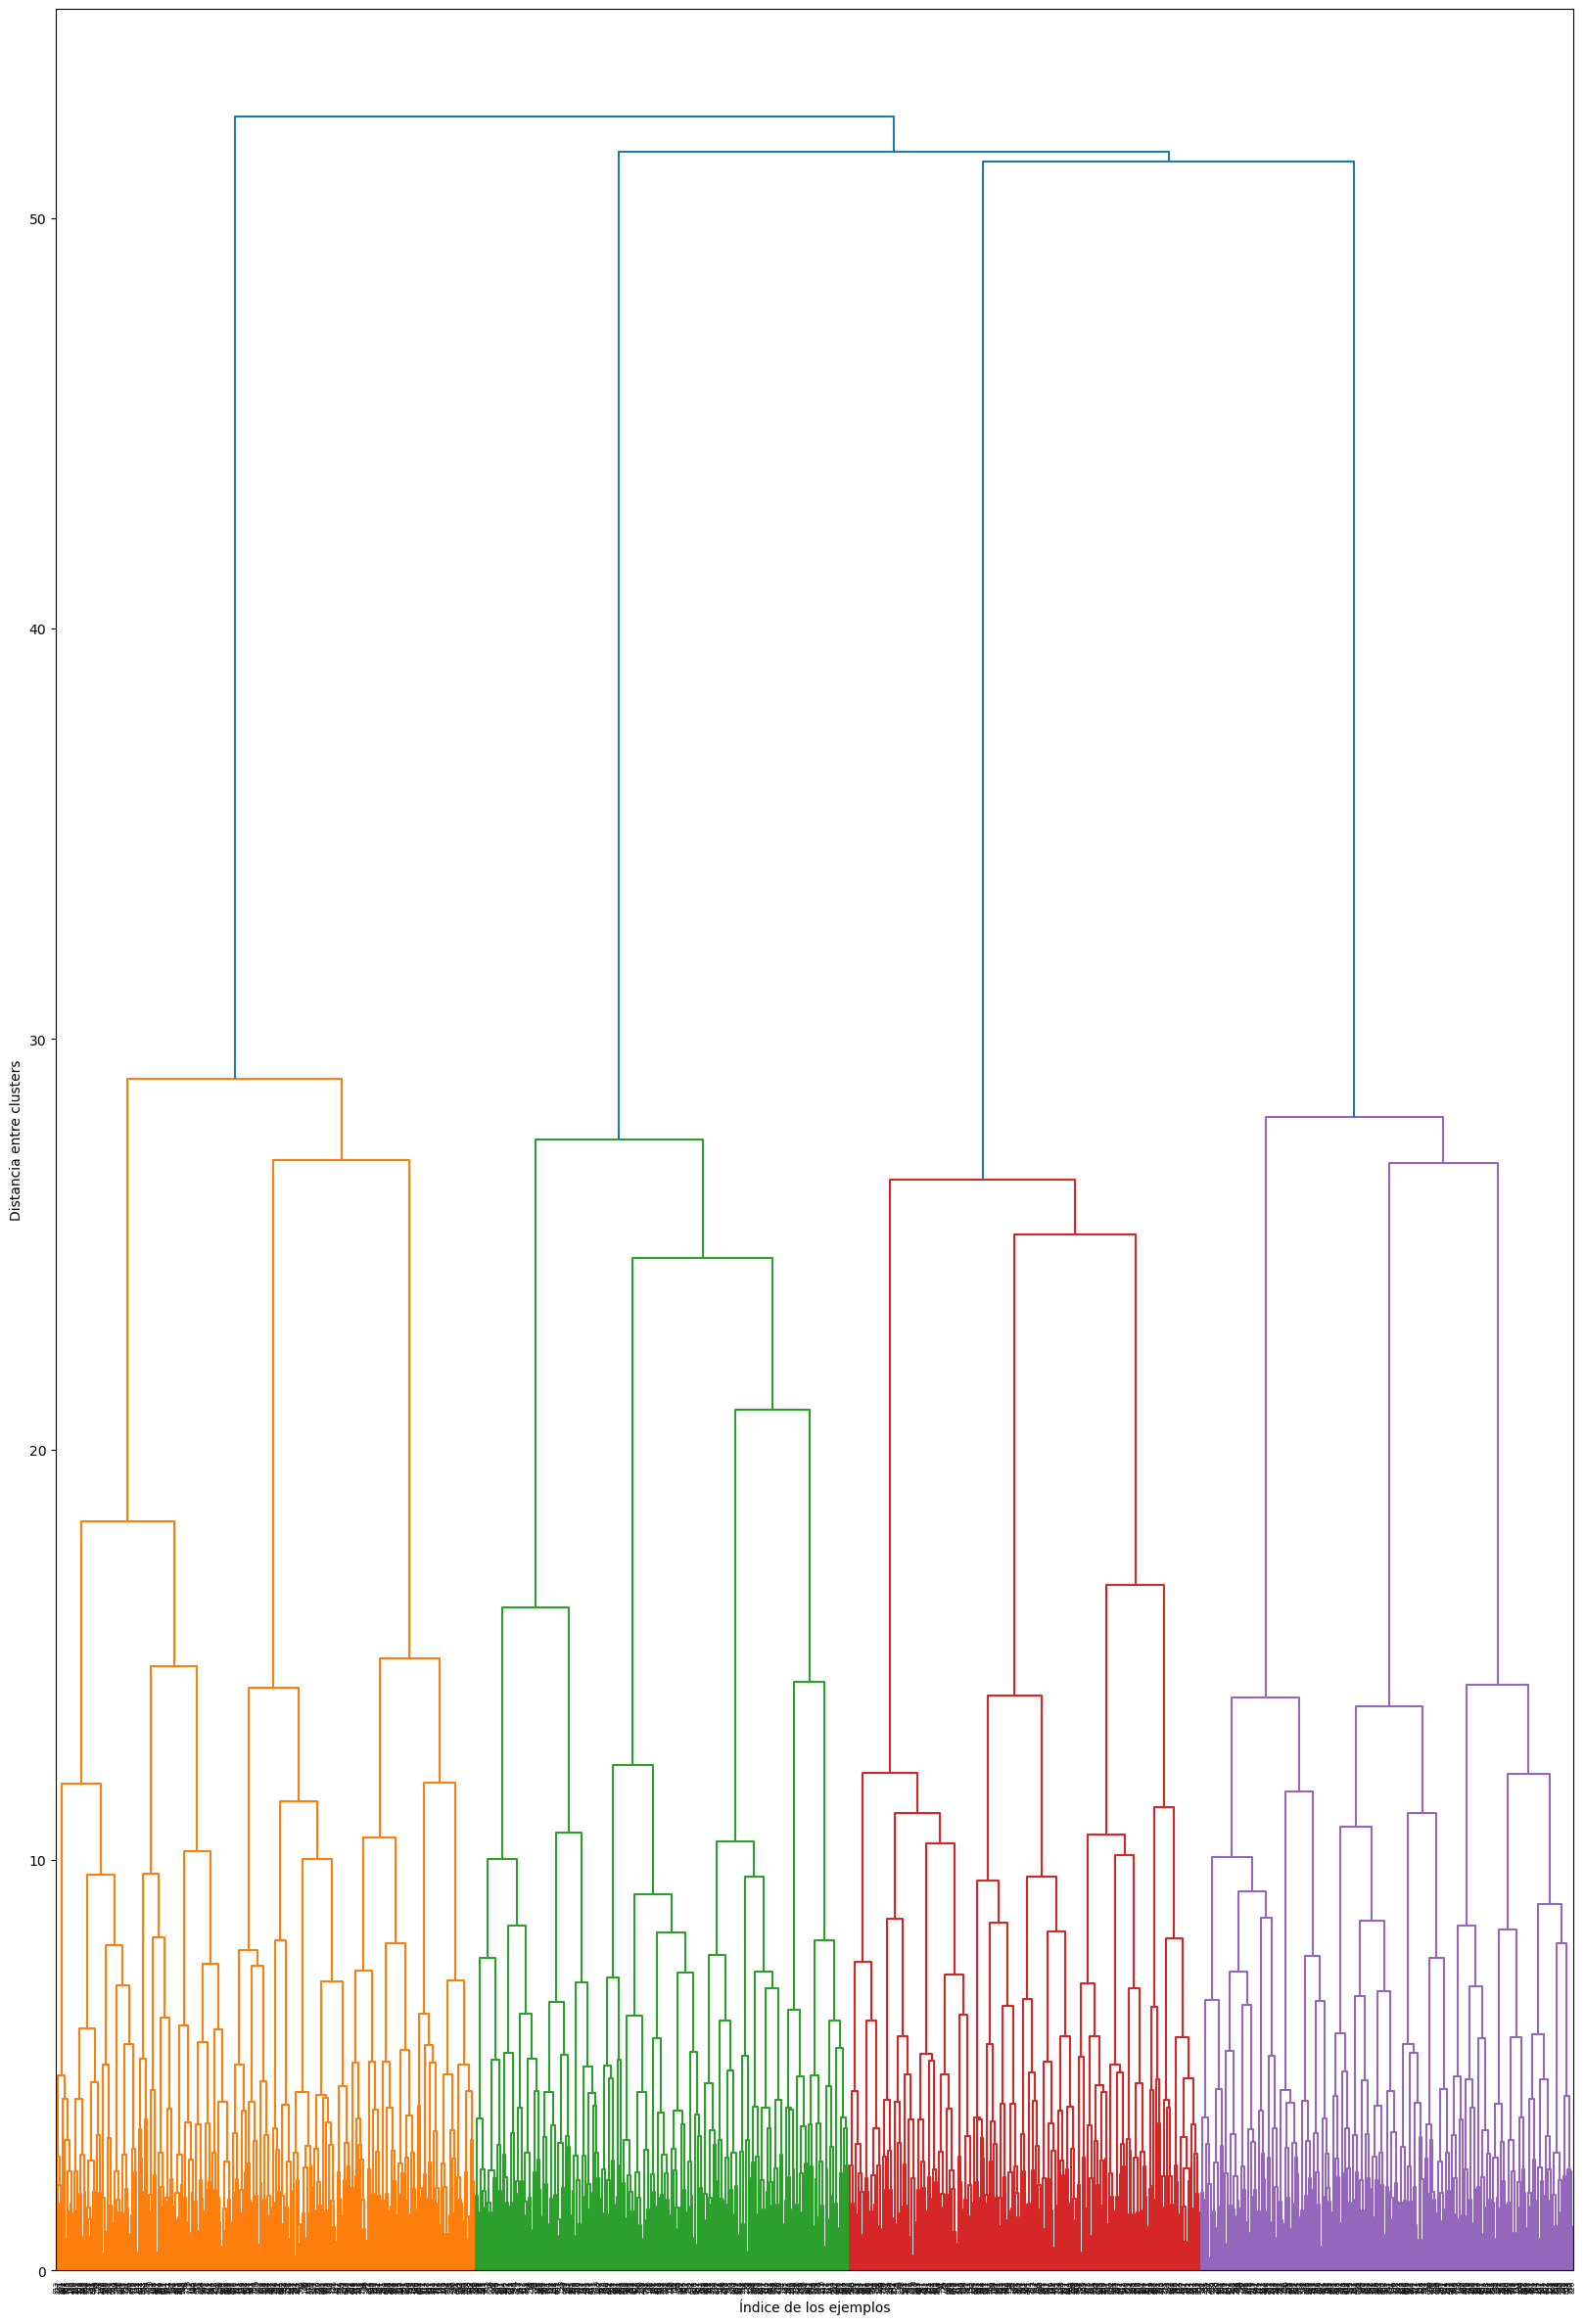

In [24]:
from scipy.cluster.hierarchy import dendrogram, ward

# Aplicamos ward clustering a los datos
# La función ward de SciPy devuelve una matriz con las distancias al realizar el agrupamiento
linkage_array = ward(df_prep_agg)


# Dendrograma para linkage_array que contiene las distancias entre clusters
plt.figure(figsize=(20, 30))
dendrogram(linkage_array)
plt.xlabel("Índice de los ejemplos")
plt.ylabel("Distancia entre clusters")
plt.show()

### Analisis 

El dendograma generado usa el método por defecto de hacer enlaces ("ward"), que es el mismo que el usado en la aglomeración jerarquica. La altura en este diagrama representa la distancia entre los clusteres que se estan formando; donde clusteres de altura similar muestran grupos similares; y conforme aumenta la altura en el diagrama se da una mejor clasificación; eventualmente llegando a un punto donde las agrupaciones son optimas, y se obtiene un minimo de clusteres.

El número de clusteres se comienza a estabilizar cerca de una altura de 25, donde se pueden observar 9 clusteres. Al final de la clasificación, se producen cuatro clusteres a partir de una altura de aprox. 30, y comparando con el resultado de la agrupación aglomerativa, se observa que estos grupos nuevamente corresponden a los niveles de la variable *tiempo de viaje*. El hecho de que se comienze a estabilizar a una altura baja muestra que se esta agrupando eficientemente los puntos de datos.

## Conclusiones

### Analisis de compoentes principales PCA

- Se realizó la construccion del modelo de componentes principales, aplicando transformaciones respectivas a los datos. Se encontraron 15 componentes principales, pero de estos solamente son significativos 11 usando el criterio de la mayor conservación de la varianza: estos 11 componentes son capaces de explicar cerca del $97\%$ acumulado de la varianza. La reducción de variables ayuda a los algoritmos de clasificación, al reducir la diferencia de escala y mejorar la ejecución.

- Se pudo reducir la dimensionalidad del problema: se paso de 15 variables (10 caracteristicas y 15 despues de trasnformaciones) a usar 11 componentes en la realización de los modelos. Una reducción más significativa de variables se podrian alcanzar, eligiendo unicamente los componentes que expliquen más varianza que las variables originales. En este caso se podria reducir hasta 8 componentes. 

### Clasificación de vecinos mas cercanos KNN

- El modelo de KNN, entrenado con componentes principales para mejorar el agrupamiento, logró encontrar 4 clusteres de datos. Se observa que los tamaños de los clusteres son todos similares, y que las estadisticas de resumen son bastante similares, hallandose que el criterio principal de clasificación fue la variable categorica del *tiempo de viaje*. El entrenamiento puede ser de utilidad si se modifica y da un menor peso a las variables categoricas, pudiendo ser usado para encontrar grupos con estadisticas similares y dirigir una estrategia de precios más atrativa a los grupos encontrados.

- Observando los graficos de clusteres, se observa que todos son similares en forma, pero se diferencian ligeramente en dezplazamiento y variación ligeras de las caracteristicas. Al entrenar el modelo removiendo la variable *tiempo de viaje*, se encontró que el metodo KNN eligia la siguiente variable mas relevante: *locación del viaje*. 

### Aglomeración Jerarquica

- El modelo de aglomeración jerarquica, usando una transformación en componentes principales, logró agrupar el conjunto de datos en cuatro grupos. Se encontró que los resultados fueron similares al agrupamiento KNN, ya que los metodos de agrupación tambien usa las variables categoricas. La principal variable de agrupación fue el *tiempo del viaje*. Tambien se observó que quitando la variable, se agrupa por otra variable categorica: *locación del viaje*. El algoritmo tambien puede usarse para crear grupos aleatorios a los cuales ofrecer mejores precios, pero se debe quitar mas influencia a las variables categoricas. 

- El dendograma de la agrupación revela que el algoritmo usando el metodo de enlace `ward` comienza estabilizarse alrededor de 9 clusteres, y converge a cuatro clusteres al final, que corresponden a los niveles del *tiempo de viaje* :  *mañana*, *tardes*, *anochecer* y *noche*. El dendograma confirma que el número optimo de clusteres de cuatro, y esta de acuerdo con los otros metodos de agrupamiento. 

## Enlaces Sustentación:

## [Diapositivas](https://view.genially.com/6726f0be72f852199c8acc34/dossier-reporting-informe-aprendizaje-estadistico-no-supervisado)

## [Presentación](https://youtu.be/gYF5fw7rs8A)

# Referencias

- Kane, F. (2017). Hands-On Data Science and Python Machine Learning. Packt
Publishing.

- Massaron, L.; Boschetti, A. Regression Analysis with Python. Packt Publishing.

- Rubio, M. (2019). Estadística con aplicaciones en R. Utadeo.
